**Questions:**

* Why is my network worse than dde? Any improvements?

* How to use tensorboard?

* How to implement physics informed loss? Is it better to use pytorch for this?

* Weird text files?

* Warning in last cell?

**To-do:**

* structure inputs for DeepONet class

* comments

In [1101]:
import os
os.environ["DDE_BACKEND"] = "pytorch"  # Set backend to PyTorch before importing deepxde

In [1102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [1103]:
# Define network class (we use the same base structure for both branch and trunk)
class Network(nn.Module):
    def __init__(self, layer_sizes, kernel_initializer=None):
        super().__init__()
        
    

        self.linears = torch.nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            torch.nn.init.xavier_normal_(self.linears[-1].weight)
            torch.nn.init.zeros_(self.linears[-1].bias)
        
    def forward(self, inputs):
        x = inputs
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        return x


In [1104]:
class DeepONet(nn.Module):
    def __init__(self, layer_sizes_branch, layer_sizes_trunk, kernel_initializer=None):
        super(DeepONet, self).__init__()
        
        # Initialize branch and trunk networks
        self.branch = Network(layer_sizes_branch, kernel_initializer)
        self.trunk = Network(layer_sizes_trunk, kernel_initializer)
        
        # bias term
        self.bias = nn.Parameter(torch.zeros(1))

    
    def forward(self, input):
        # Forward pass through the networks
        branch_output = self.branch(input[:, :1])
        trunk_output = self.trunk(input[:, 1:])
        
        # Combine the outputs
        output = torch.sum(branch_output * trunk_output, dim=1) + self.bias
        return output


In [1105]:
class Model():
    def __init__(self, train_data, test_data, net):
        self.train_data = train_data
        self.test_data = test_data
        self.net = net
        self.vlosshistory = []
        self.tlosshistory = []
        
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
                
    def train_one_epoch(self):
            
            running_loss = 0.
            iter = 0
            for i, data in enumerate(self.train_data):

                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = self.loss_fn(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                iter += 1

            return running_loss / iter
        
        
    def train(self, epochs):
        
        self.epochs = []
        
        print('Epoch \t Train loss \t Test loss')
        
    
        epoch_number = 0
        best_vloss = 1_000_000.

        for epoch in range(epochs):
            
            self.net.train(True)
            avg_loss = self.train_one_epoch()

        
            if epoch % int(epochs / 10) == int(epochs / 10) - 1:
                self.net.eval()
                running_vloss = 0.0
                iter = 0
                with torch.no_grad():
                    for i, vdata in enumerate(self.test_data):
                        vinputs, vlabels = vdata
                        voutputs = self.net(vinputs)
                        vloss = self.loss_fn(voutputs, vlabels)
                        running_vloss += vloss
                        iter += 1
                

                avg_vloss = running_vloss / iter
                self.vlosshistory.append(avg_vloss)
                self.tlosshistory.append(avg_loss)
                self.epochs.append(epoch)
                
                print('{} \t {:.2e} \t {:.2e}'.format(epoch + 1, avg_loss, avg_vloss))
                
            
            #self.optimizer.param_groups[0]['lr'] *= 0.9
            
    def plot_losshistory(self):
        # Plot the loss trajectory
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(self.epochs, self.tlosshistory, label='Training loss')
        ax.plot(self.epochs, self.vlosshistory, label='Test loss')
        ax.set_title("Training Loss History")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_yscale('log')
        ax.grid(True)
        ax.legend()
        plt.show()
            
    

In [1106]:
# Set constants
q0, p0 = 1, 1
Tmin, Tmax = 0, 10
w_low, w_high = 0, 1

In [1107]:
# Get analytical solution of the BVP for given t and omega
def analytic_solution(w, t, q0=q0, p0=p0):
    return q0*np.cos(w @ t.T) + p0*np.diag(1/w.flatten())@np.sin(w @ t.T)

# Returns a (len(w), len(t))-shape matrix

In [1108]:
# Create training data
batch_size = 512

w_train = np.random.uniform(low=w_low, high=w_high, size=(100,1))
t_train = np.random.uniform(low=Tmin, high=Tmax, size=(100,1))
x, y = np.meshgrid(w_train, t_train)
X_train = np.vstack((x.ravel(), y.ravel())).T

y_train = analytic_solution(w_train, t_train).T.flatten().astype(np.float32)

tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

training_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

In [1109]:
# Create training data
w_test = np.random.uniform(low=w_low, high=w_high, size=(100,1))
t_test = np.random.uniform(low=Tmin, high=Tmax, size=(100,1))
x, y = np.meshgrid(w_test, t_test)
X_test = np.vstack((x.ravel(), y.ravel())).T

y_test = analytic_solution(w_test, t_test).T.flatten().astype(np.float32)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.Tensor(y_test)

testing_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
validation_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

In [1110]:
# Initialize the model
net = DeepONet([1, 128, 128, 128, 128], [1, 128, 128, 128, 128])
model = Model(training_loader, validation_loader, net)
model.train(epochs=500)

Epoch 	 Train loss 	 Test loss
50 	 8.49e-03 	 6.65e-03
100 	 5.21e-03 	 8.97e-03
150 	 4.85e-03 	 3.37e-03
200 	 5.55e-03 	 3.70e-03
250 	 4.95e-03 	 4.85e-03
300 	 1.47e-03 	 9.29e-04
350 	 5.79e-04 	 8.34e-04
400 	 3.67e-03 	 1.16e-03
450 	 5.16e-04 	 2.85e-04
500 	 2.35e-03 	 6.71e-04


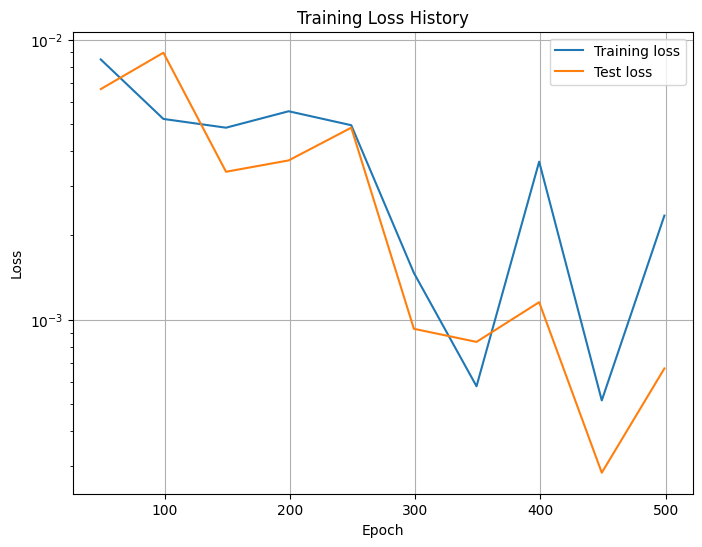

In [1111]:
model.plot_losshistory()

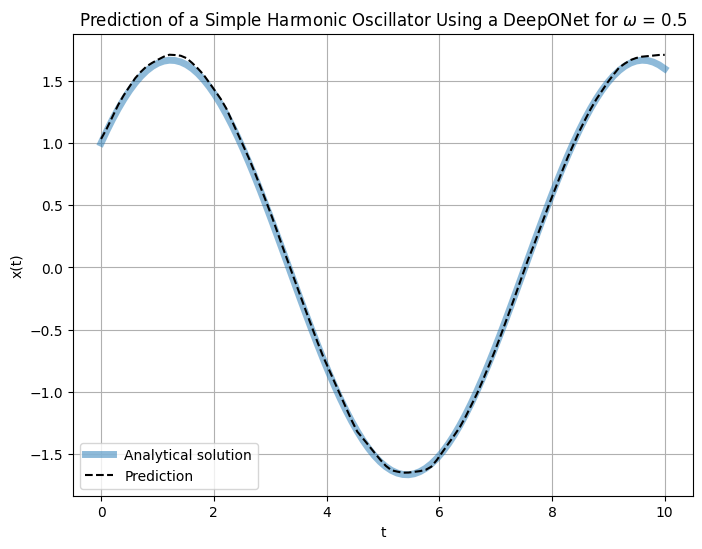

In [1112]:
# Plot model prediction for one omega

# Get model prediction

t_vec = np.linspace(Tmin, Tmax, 100).reshape(-1, 1)
w = np.array([0.75]).reshape(-1, 1)

x, y = np.meshgrid(w, t_vec)

input = np.vstack((x.ravel(), y.ravel())).T
input = torch.Tensor(input)

pred = model.net(input)


# Get corresponding ground truth
ground_truth = analytic_solution(w, t_vec)

# Plot prediction vs. solution
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_vec.flatten(), ground_truth.flatten(), label='Analytical solution', alpha=0.5, linewidth=5)
ax.plot(t_vec.flatten(), pred.tolist(), '--', label='Prediction', c='k')
ax.set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet for $\omega$ = 0.5')
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.legend()
ax.grid(True)
plt.show()